# Single-Image 3D Reconstruction en ModelNet40 con **PyTorch3D** (Torch 2.6 / CUDA 12.4)

## Chequeo de entorno

In [1]:
import sys, os, platform, shutil, json, subprocess
try:
    import torch
except Exception as e:
    raise SystemExit('PyTorch no está instalado en este kernel. Instálalo antes de continuar.') from e

print(f'Python: {sys.version.split()[0]}')
print(f'Torch:  {torch.__version__}')
print(f'CUDA (torch): {getattr(torch.version, "cuda", None)}')
print('CUDA disponible:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
    print('Compute capability:', torch.cuda.get_device_capability(0))

print('\nChecando herramientas del sistema...')
nvcc_path = shutil.which('nvcc')
print('nvcc:', nvcc_path if nvcc_path else 'NO encontrado (instala CUDA Toolkit y agrega bin a PATH)')

cl_path = shutil.which('cl')
print('cl.exe (MSVC):', cl_path if cl_path else "NO encontrado (instala 'Desktop development with C++' / Build Tools)")

print('\nSalida de nvidia-smi (si existe):')
try:
    ret = subprocess.run(['nvidia-smi'], check=False, capture_output=True, text=True)
    print(ret.stdout if ret.stdout else ret.stderr)
except Exception as e:
    print('nvidia-smi no disponible:', e)

Python: 3.11.11
Torch:  2.6.0+cu124
CUDA (torch): 12.4
CUDA disponible: True
GPU: NVIDIA GeForce RTX 3060
Compute capability: (8, 6)

Checando herramientas del sistema...
nvcc: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.4\bin\nvcc.EXE
cl.exe (MSVC): C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.44.35207\bin\HostX64\x64\cl.EXE

Salida de nvidia-smi (si existe):
Sun Oct  5 11:19:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.88                 Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=============

In [2]:
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.6"
os.environ["CMAKE_GENERATOR"] = "Ninja"

### Smoke test: render de un icosphere

Device: cuda


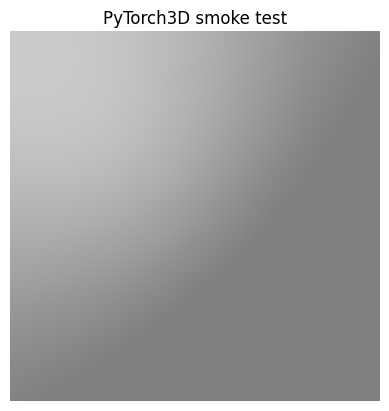

In [3]:
import torch, math
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.renderer import (
    PerspectiveCameras, RasterizationSettings, MeshRenderer, MeshRasterizer,
    SoftPhongShader, PointLights, TexturesVertex
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

base = ico_sphere(level=3, device=device)
verts = base.verts_packed()
faces = base.faces_packed()
tex = TexturesVertex(verts_features=torch.ones_like(verts)[None])
mesh = Meshes(verts=[verts], faces=[faces], textures=tex).to(device)

cameras = PerspectiveCameras(device=device)
raster_settings = RasterizationSettings(image_size=256)
lights = PointLights(device=device, location=[[2, 2, 2]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights),
)

image = renderer(mesh)
plt.imshow(image[0, ..., :3].detach().cpu().numpy())
plt.title('PyTorch3D smoke test')
plt.axis('off'); plt.show()

### Utils: Cargar `.off` y muestrear cloud de puntos (ModelNet40)

In [4]:
import numpy as np, pathlib, trimesh

def load_off(path):
    mesh = trimesh.load_mesh(path, file_type='off', process=False)
    if not isinstance(mesh, trimesh.Trimesh):
        mesh = mesh.dump(concatenate=True)
    mesh.apply_translation(-mesh.centroid)
    scale = max(mesh.extents)
    if scale > 0:
        mesh.apply_scale(1.0/scale)
    return mesh

def sample_point_cloud(mesh: trimesh.Trimesh, n_points: int = 2048):
    pts, _ = trimesh.sample.sample_surface(mesh, n_points)
    return pts.astype(np.float32)


### Baseline **PSGN** (imagen → nube de puntos)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

class PSGN(nn.Module):
    def __init__(self, n_points: int = 2048, pretrained: bool = True, feat_dim: int = 512):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = resnet18(weights=weights)
        backbone.fc = nn.Identity()
        self.encoder = backbone
        self.mlp = nn.Sequential(
            nn.Linear(feat_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, n_points * 3)
        )
        self.n_points = n_points

    def forward(self, x):
        f = self.encoder(x)
        out = self.mlp(f)
        pts = out.view(-1, self.n_points, 3)
        return pts


### Loss: Chamfer Distance

In [6]:
import torch

def chamfer_distance(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    d = torch.cdist(x, y, p=2)
    mins1 = d.min(dim=2).values
    mins2 = d.min(dim=1).values
    return (mins1.mean(dim=1) + mins2.mean(dim=1)).mean()


### Prueba de Entrenamiento mínimo

In [7]:
import torch, time
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Dataset dummy
class DummyPairs(Dataset):
    def __init__(self, num=64, n_points=2048):
        self.num = num
        self.n_points = n_points
        self.tf = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])
    def __len__(self):
        return self.num
    def __getitem__(self, i):
        img_np = (np.random.rand(256, 256, 3) * 255).astype('uint8')
        img = Image.fromarray(img_np)
        pc = torch.randn(self.n_points, 3) * 0.25
        return self.tf(img), pc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PSGN(n_points=2048, pretrained=True).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

ds = DummyPairs(num=128, n_points=2048)

dl = DataLoader(
    ds, batch_size=8, shuffle=True,
    num_workers=0,                # ← evita multiprocessing en Jupyter/Windows
    pin_memory=(device.type=='cuda'),
    persistent_workers=False
)

# Sanity check
imgs, pc_gt = next(iter(dl))
print("Batch OK:", imgs.shape, pc_gt.shape)

# Train 
for epoch in range(2):
    model.train()
    loss_epoch = 0.0
    t0 = time.time()
    for imgs, pc_gt in dl:
        imgs = imgs.to(device, non_blocking=True)
        pc_gt = pc_gt.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            pc_pred = model(imgs)
            loss = chamfer_distance(pc_pred, pc_gt)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        loss_epoch += loss.item() * imgs.size(0)
    print(f"Epoch {epoch+1} | Loss: {loss_epoch/len(ds):.4f} | {time.time()-t0:.1f}s")


C:\Users\fabri\AppData\Local\Temp\ipykernel_35452\1107575679.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))
C:\Users\fabri\AppData\Local\Temp\ipykernel_35452\1107575679.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Batch OK: torch.Size([8, 3, 224, 224]) torch.Size([8, 2048, 3])
Epoch 1 | Loss: 0.0950 | 2.1s
Epoch 2 | Loss: 0.0945 | 1.0s


### Exportar cloud de puntos a `.ply`

In [8]:
import open3d as o3d
import numpy as np
import torch

with torch.no_grad():
    sample = torch.randn(2048,3).cpu().numpy()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(sample.astype(np.float64))
o3d.io.write_point_cloud('sample_pred.ply', pcd)
print('Guardado:', 'sample_pred.ply')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Guardado: sample_pred.ply


## Entrenamiento con dataset real

### Configura la ruta del dataset y lista los .off

In [9]:
import pathlib, os, glob

DATA_DIR = pathlib.Path(r"C:\Users\fabri\Desktop\Portfolio\Reconstruccion-3D\data")
assert DATA_DIR.exists(), f"No existe: {DATA_DIR}"

train_offs = sorted(DATA_DIR.glob("*\\train\\*.off"))
test_offs  = sorted(DATA_DIR.glob("*\\test\\*.off"))
print("Train .off:", len(train_offs), "| Test .off:", len(test_offs))
train_offs[:3]

Train .off: 0 | Test .off: 0


[]

### Renderer de PyTorch3D (RGB simple)

In [10]:
import torch
from pytorch3d.renderer import (
    FoVPerspectiveCameras, RasterizationSettings, MeshRenderer, MeshRasterizer,
    SoftPhongShader, PointLights, look_at_view_transform
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_renderer(image_size=224):
    cameras = FoVPerspectiveCameras(device=device)
    raster_settings = RasterizationSettings(image_size=image_size)
    lights = PointLights(device=device, location=[[2.0, 2.0, 2.0]])
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights),
    )
    return renderer

renderer = make_renderer(image_size=224)
print("Renderer listo en", device)


Renderer listo en cuda


### Utilidades: cargar .off, normalizar y construir Meshes de PyTorch3D

In [11]:
import numpy as np, trimesh
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex

def load_off_unit(path_off: pathlib.Path):
    mesh = trimesh.load_mesh(path_off, file_type='off', process=False)
    if not isinstance(mesh, trimesh.Trimesh):
        mesh = mesh.dump(concatenate=True)
    mesh.apply_translation(-mesh.centroid)
    scale = max(mesh.extents)
    if scale > 0:
        mesh.apply_scale(1.0/scale)
    return mesh

def trimesh_to_p3d(mesh: trimesh.Trimesh, device=device):
    verts = torch.tensor(np.asarray(mesh.vertices), dtype=torch.float32, device=device)
    faces = torch.tensor(np.asarray(mesh.faces), dtype=torch.int64, device=device)
    tex = TexturesVertex(verts_features=torch.ones_like(verts)[None])
    return Meshes(verts=[verts], faces=[faces], textures=tex)

def sample_point_cloud(mesh: trimesh.Trimesh, n_points=2048):
    pts, _ = trimesh.sample.sample_surface(mesh, n_points)
    return torch.tensor(pts, dtype=torch.float32)


### Dataset real: render RGB + nube de puntos GT

In [12]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import math, random

class ModelNetRenderDataset(Dataset):
    def __init__(self, off_paths, n_points=2048, image_size=224, views=None, pretrained_norm=True):
        self.off_paths = list(off_paths)
        self.n_points = n_points
        self.image_size = image_size
        self.views = views or [  # (elev, azim, dist)
            (15, -30, 2.7), (15, 30, 2.7), (25, -45, 2.7), (25, 45, 2.7),
            (30, 0, 2.7), (10, 60, 2.7), (10, -60, 2.7)
        ]
        mean_std = ([0.485,0.456,0.406],[0.229,0.224,0.225]) if pretrained_norm else ([0.5]*3,[0.5]*3)
        self.tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(*mean_std),
        ])

    def __len__(self):
        return len(self.off_paths)

    @torch.no_grad()
    def __getitem__(self, i):
        path = self.off_paths[i]
        mesh_tm = load_off_unit(path)
        pc_gt   = sample_point_cloud(mesh_tm, self.n_points)     # (N,3) CPU

        # Render en vista aleatoria
        elev, azim, dist = random.choice(self.views)
        R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim, device=device)
        mesh_p3d = trimesh_to_p3d(mesh_tm, device=device)

        images = renderer(mesh_p3d, cameras=FoVPerspectiveCameras(device=device, R=R, T=T))
        img = images[0, ..., :3].detach().cpu().numpy()  # (H,W,3), float32 [0,1]
        img = Image.fromarray((img*255).astype('uint8'))

        # Resize aquí para mantener antialias nativo de PIL
        img = img.resize((self.image_size, self.image_size), Image.BILINEAR)
        return self.tf(img), pc_gt

### Check: batch real

In [13]:
from pathlib import Path

ROOT = Path(r"C:\Users\fabri\Desktop\Portfolio\Reconstruccion-3D\data").resolve()
assert ROOT.exists(), f"No existe: {ROOT}"

all_offs = list(ROOT.rglob("*.off"))
print("Total .off encontrados:", len(all_offs))
if len(all_offs) < 10:
    print("⚠️ Muy pocos .off. Revisa la ruta ROOT o si el ZIP se descomprimió bien.")

def has_part(p: Path, name: str) -> bool:
    return any(part.lower() == name for part in p.parts)

train_offs = sorted([p for p in all_offs if has_part(p, "train")])
test_offs  = sorted([p for p in all_offs if has_part(p, "test")])

print("Train .off:", len(train_offs), "| Test .off:", len(test_offs))
print("Ejemplos train:", train_offs[:3])
print("Ejemplos test :", test_offs[:3])


Total .off encontrados: 12311
Train .off: 9843 | Test .off: 2468
Ejemplos train: [WindowsPath('C:/Users/fabri/Desktop/Portfolio/Reconstruccion-3D/data/ModelNet40/ModelNet40/airplane/train/airplane_0001.off'), WindowsPath('C:/Users/fabri/Desktop/Portfolio/Reconstruccion-3D/data/ModelNet40/ModelNet40/airplane/train/airplane_0002.off'), WindowsPath('C:/Users/fabri/Desktop/Portfolio/Reconstruccion-3D/data/ModelNet40/ModelNet40/airplane/train/airplane_0003.off')]
Ejemplos test : [WindowsPath('C:/Users/fabri/Desktop/Portfolio/Reconstruccion-3D/data/ModelNet40/ModelNet40/airplane/test/airplane_0627.off'), WindowsPath('C:/Users/fabri/Desktop/Portfolio/Reconstruccion-3D/data/ModelNet40/ModelNet40/airplane/test/airplane_0628.off'), WindowsPath('C:/Users/fabri/Desktop/Portfolio/Reconstruccion-3D/data/ModelNet40/ModelNet40/airplane/test/airplane_0629.off')]


In [14]:
# (Reusa tu ModelNetRenderDataset/renderer ya definidos)
assert len(train_offs) > 0 and len(test_offs) > 0, "No se hallaron .off en train/test. Ajusta ROOT o descomprime el dataset."

train_ds = ModelNetRenderDataset(train_offs, n_points=2048, image_size=224, pretrained_norm=True)
test_ds  = ModelNetRenderDataset(test_offs,  n_points=2048, image_size=224, pretrained_norm=True)

from torch.utils.data import DataLoader
dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0, pin_memory=(device.type=='cuda'))

imgs, pc_gt = next(iter(dl))
print("imgs:", imgs.shape, "| pc_gt:", pc_gt.shape)

imgs: torch.Size([4, 3, 224, 224]) | pc_gt: torch.Size([4, 2048, 3])


### Entrenar el PSGN con dataset

In [16]:
model = PSGN(n_points=2048, pretrained=True).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0, pin_memory=(device.type=='cuda'))

for epoch in range(10):
    model.train()
    loss_epoch = 0.0
    for imgs, pc_gt in train_dl:
        imgs  = imgs.to(device, non_blocking=True)
        pc_gt = pc_gt.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            pc_pred = model(imgs)
            loss = chamfer_distance(pc_pred, pc_gt)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        loss_epoch += loss.item() * imgs.size(0)
    print(f"Epoch {epoch+1} | Loss: {loss_epoch/len(train_ds):.5f}")

C:\Users\fabri\AppData\Local\Temp\ipykernel_35452\955599031.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
C:\Users\fabri\AppData\Local\Temp\ipykernel_35452\955599031.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 1 | Loss: 0.10243
Epoch 2 | Loss: 0.08702
Epoch 3 | Loss: 0.08124
Epoch 4 | Loss: 0.07748
Epoch 5 | Loss: 0.07460
Epoch 6 | Loss: 0.07238
Epoch 7 | Loss: 0.07065
Epoch 8 | Loss: 0.06930
Epoch 9 | Loss: 0.06815
Epoch 10 | Loss: 0.06721


### Export .ply 

In [17]:
import open3d as o3d

model.eval()
with torch.no_grad():
    img, pc_gt = test_ds[0]
    pc_pred = model(img.unsqueeze(0).to(device)).squeeze(0).cpu().numpy()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc_pred.astype(np.float64))
o3d.io.write_point_cloud("recon_pred.ply", pcd)
print("Guardado:", os.path.abspath("recon_pred.ply"))

Guardado: c:\Users\fabri\Desktop\Portfolio\Reconstruccion-3D\recon_pred.ply


### Visualizacion .ply

In [18]:
import open3d as o3d
pcd = o3d.io.read_point_cloud(r"C:\Users\fabri\Desktop\Portfolio\Reconstruccion-3D\recon_pred.ply")
o3d.visualization.draw_geometries([pcd]) 

### Guardar modelo

In [19]:
import torch
torch.save(
    {"state_dict": model.state_dict(), "n_points": getattr(model, "n_points", 2048)},
    "psgn_modelnet40.pt"
)

### Evaluación (Chamfer y F-score@τ)

In [20]:
import torch, numpy as np, open3d as o3d

# elige un índice de test
i = 0
img, pc_gt = test_ds[i]                 # (3, H, W), (N,3) tensor CPU
pc_pred = model(img.unsqueeze(0).to(device)).squeeze(0).detach().cpu()  # (N,3)

# Chamfer
def chamfer_torch(x, y):
    d = torch.cdist(x, y, p=2)
    return d.min(1).values.mean() + d.min(0).values.mean()

cd = chamfer_torch(pc_pred, pc_gt)
print("Chamfer:", float(cd))

# F-score@tau (tau ~ 1% del diámetro)
def fscore(pred, gt, tau=0.01):
    # normaliza por el radio del GT
    scale = (gt.max(0).values - gt.min(0).values).norm()
    thr = tau * float(scale)

    D = torch.cdist(pred, gt, p=2)
    prec = (D.min(1).values < thr).float().mean()
    rec  = (D.min(0).values < thr).float().mean()
    if prec + rec == 0: return 0.0, float(prec), float(rec)
    F = 2 * (prec * rec) / (prec + rec)
    return float(F), float(prec), float(rec)

F, P, R = fscore(pc_pred, pc_gt, tau=0.01)
print(f"F@1%: {F:.3f} (P={P:.3f}, R={R:.3f})")

# Exportar ambos para inspección
pred_o3d = o3d.geometry.PointCloud(); pred_o3d.points = o3d.utility.Vector3dVector(pc_pred.numpy().astype(np.float64))
gt_o3d   = o3d.geometry.PointCloud(); gt_o3d.points   = o3d.utility.Vector3dVector(pc_gt.numpy().astype(np.float64))
o3d.io.write_point_cloud("recon_pred_eval.ply", pred_o3d)
o3d.io.write_point_cloud("recon_gt_eval.ply",   gt_o3d)

Chamfer: 0.031435608863830566
F@1%: 0.486 (P=0.500, R=0.473)


True

### Tests

### Utils (denormalizar y figura side-by-side)

In [21]:
from pathlib import Path
import os, time, csv
import numpy as np
import torch
import matplotlib.pyplot as plt

TESTS_DIR = Path(r"C:\Users\fabri\Desktop\Portfolio\Reconstruccion-3D\tests")
TESTS_DIR.mkdir(parents=True, exist_ok=True)

# Invertir normalización ImageNet (para mostrar la imagen de entrada)
def denorm_imagen(img_t: torch.Tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_t.device).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=img_t.device).view(3,1,1)
    x = (img_t * std + mean).clamp(0,1)
    x = (x.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
    return x

# Guardar triptico: entrada | pred | GT
def save_triptych(img_t, pc_pred, pc_gt, out_png, title=None):
    fig = plt.figure(figsize=(12,4))

    # Panel 1: imagen
    ax0 = fig.add_subplot(1,3,1)
    ax0.imshow(denorm_imagen(img_t))
    ax0.set_title("Input image")
    ax0.axis("off")

    # Panel 2: pred
    ax1 = fig.add_subplot(1,3,2, projection="3d")
    p = pc_pred.detach().cpu().numpy()
    ax1.scatter(p[:,0], p[:,1], p[:,2], s=1)
    lim = np.max(np.abs(p)) * 1.1 if p.size else 1
    ax1.set_xlim(-lim, lim); ax1.set_ylim(-lim, lim); ax1.set_zlim(-lim, lim)
    ax1.set_title("Prediction (point cloud)"); ax1.set_axis_off()

    # Panel 3: GT
    ax2 = fig.add_subplot(1,3,3, projection="3d")
    g = pc_gt.detach().cpu().numpy()
    lim2 = np.max(np.abs(g)) * 1.1 if g.size else 1
    ax2.scatter(g[:,0], g[:,1], g[:,2], s=1)
    ax2.set_xlim(-lim2, lim2); ax2.set_ylim(-lim2, lim2); ax2.set_zlim(-lim2, lim2)
    ax2.set_title("Ground Truth"); ax2.set_axis_off()

    if title:
        fig.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout()
    fig.savefig(out_png, dpi=150, bbox_inches="tight")
    plt.close(fig)

### Métricas (Chamfer y F-score@τ)

In [22]:
import open3d as o3d

def chamfer_torch(x: torch.Tensor, y: torch.Tensor) -> float:
    d = torch.cdist(x, y, p=2)
    return float(d.min(1).values.mean() + d.min(0).values.mean())

def fscore_tau(pred: torch.Tensor, gt: torch.Tensor, tau=0.01):
    # umbral relativo al tamaño del GT
    scale = (gt.max(0).values - gt.min(0).values).norm()
    thr = float(tau * scale)
    D = torch.cdist(pred, gt, p=2)
    prec = (D.min(1).values < thr).float().mean()
    rec  = (D.min(0).values < thr).float().mean()
    F = 0.0 if (prec+rec)==0 else 2*(prec*rec)/(prec+rec)
    return float(F), float(prec), float(rec)

def save_ply(points_t, path):
    pts = points_t.detach().cpu().numpy().astype(np.float64)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    o3d.io.write_point_cloud(str(path), pcd)

### Tests

In [23]:
import random

# Parámetros de prueba
K = 10              # cuántas muestras quieres evaluar/guardar
TAU = 0.01          # F-score@tau
random.seed(0)

# Elegimos K índices válidos
idxs = random.sample(range(len(test_ds)), k=min(K, len(test_ds)))

csv_path = TESTS_DIR / "results.csv"
write_header = not csv_path.exists()

with open(csv_path, "a", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    if write_header:
        w.writerow(["idx","category","png","ply_pred","ply_gt","chamfer","F_tau","P","R","tau"])

    model.eval()
    for i in idxs:
        # Recuperar ruta para saber la clase/categoría (según estructura ModelNet40)
        path_off = test_ds.off_paths[i]
        # ej.: ...\chair\test\chair_0001.off  => categoría = 'chair'
        category = path_off.parent.parent.name if path_off.suffix.lower()==".off" else "unknown"

        # Datos
        img_t, pc_gt = test_ds[i]                       # img normalizada; pc_gt en CPU
        with torch.no_grad():
            pc_pred = model(img_t.unsqueeze(0).to(device)).squeeze(0).cpu()

        # Métricas
        cd = chamfer_torch(pc_pred, pc_gt)
        F, P, R = fscore_tau(pc_pred, pc_gt, tau=TAU)

        # Nombres de archivos
        stamp = time.strftime("%Y%m%d-%H%M%S")
        base = f"{category}_{i}_{stamp}"
        png_path = TESTS_DIR / f"{base}.png"
        ply_pred_path = TESTS_DIR / f"{base}_pred.ply"
        ply_gt_path   = TESTS_DIR / f"{base}_gt.ply"

        # Guardar visual y PLYs
        save_triptych(img_t, pc_pred, pc_gt, png_path, title=f"{category} | CD={cd:.4f} | F@{TAU*100:.1f}%={F:.3f}")
        save_ply(pc_pred, ply_pred_path)
        save_ply(pc_gt,   ply_gt_path)

        # Registrar en CSV
        w.writerow([i, category, str(png_path), str(ply_pred_path), str(ply_gt_path), f"{cd:.6f}", f"{F:.6f}", f"{P:.6f}", f"{R:.6f}", TAU])

print("Listo ", TESTS_DIR)

Listo  C:\Users\fabri\Desktop\Portfolio\Reconstruccion-3D\tests
